# 2주차 과제

170644 박시온

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# housing 데이터 다운받기

In [2]:
import os
import tarfile
from six.moves import urllib

# housing을 자기 학번으로 변경하기
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "170644")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# 데이터 다운로드 함수
def fetch_170644_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    # housing.tgz를 학번 170644로 변경
    tgz_path = os.path.join(housing_path, "170644.tgz")
    # tgz 파일 압축해제
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_170644_data()

In [4]:
import pandas as pd

# housing.csv 읽는 함수
def load_170644_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_170644_data()

In [6]:
# 소득 카테고리 개수를 제한하기 위해 1.5로 나눔
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# 5 이상은 5로 레이블
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [7]:
# 계층적 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# 데이터를 훈련 및 테스트 세트로 분할하기 위한 인덱스를 생성해 반환
# 계층 기준 : 소득
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [8]:
# 훈련 세트 대입
housing = strat_train_set.copy()

# 데이터 분포 출력해보기

C:\Users\Sion\AppData\Local\Temp\ipykernel_15580\572992841.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


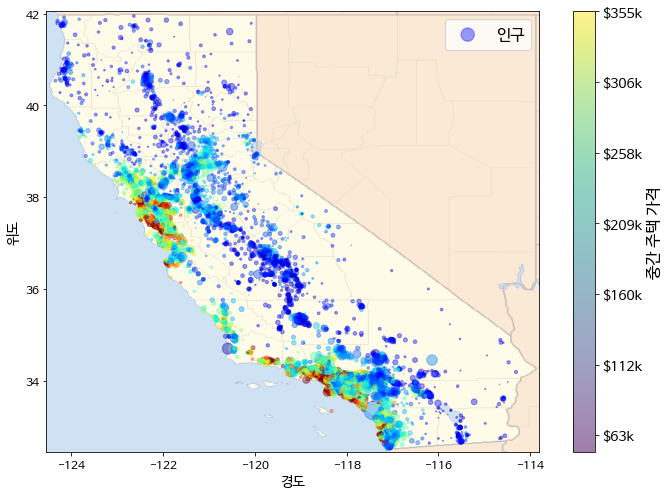

In [9]:
import matplotlib.image as mpimg
# 캘리포니아 이미지 로드
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
# 알파값 설정해 분포도가 높을수록 진한 색으로 표시
# 중간 주택 가격에 따라 색 변경
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="인구",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
# 분포도에 맞추어 캘리포니아 이미지 연동
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("위도", fontsize=14)
plt.xlabel("경도", fontsize=14)

prices = housing["median_house_value"]
# 중간 주택 가격 11등분
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
# 11등분한 값에 맞추어 컬러바 생성
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('중간 주택 가격', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

# 데이터 상관관계 출력

In [10]:
# 데이터 상관관계
corr_matrix = housing.corr()

In [11]:
# 중간 주택 가격 특성과 다른 특성 사이의 상관관계
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
income_cat            0.642256
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

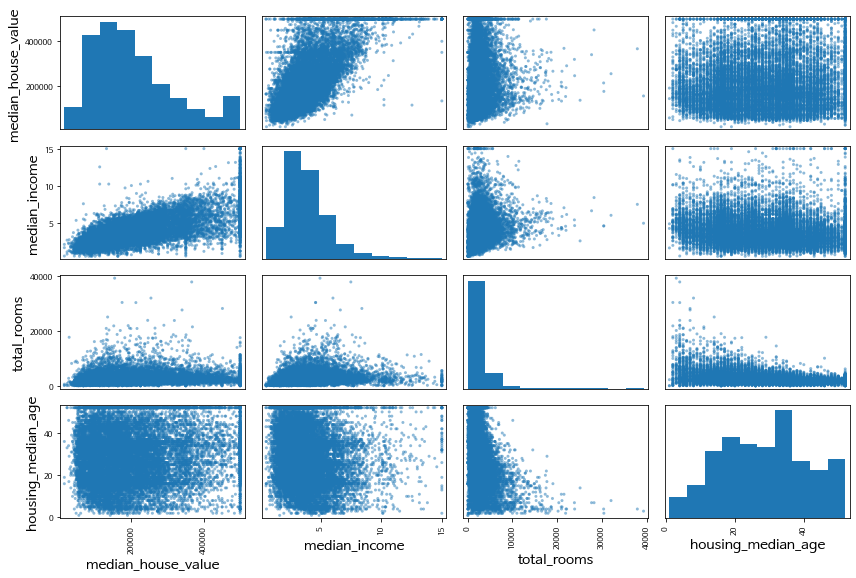

In [12]:
from pandas.plotting import scatter_matrix

# 중간 주택 가격, 중간 소득, 방 개수, 중산층 연령간 상관관계
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# 새로운 feature 추가하기

In [13]:
# 구역별 방의 총 개수와 침실의 총 개수 대신 이용할
# 가구당 방 수, 방 수당 침실 수, 가구당 인원 특성 생성
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [14]:
# 새로운 feature 상관관계 확인
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
income_cat                  0.642256
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

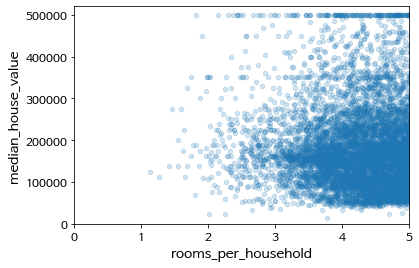

In [15]:
# 가구당 방 수 상관관계 표시
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [16]:
# 추가된 feature 확인
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,3.006783,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,1.054600,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,2.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,3.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,4.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,5.000000,141.909091,1.000000,1243.333333


# 파이프라인 설계하기
수치형 데이터 전처리

In [17]:
housing = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
housing_labels = strat_train_set["median_house_value"].copy()

In [18]:
# 누락된 특성값 확인
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY,2.0
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN,3.0
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN,3.0
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN,3.0
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN,5.0


In [19]:
# 누락된 값이 있는 샘플만 제거
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [20]:
# 중간값 데이터 준비
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [21]:
# 텍스트 특성 제거
housing_num = housing.drop('ocean_proximity', axis=1)

In [22]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

12655        INLAND
15502    NEAR OCEAN
2908         INLAND
14053    NEAR OCEAN
20496     <1H OCEAN
1481       NEAR BAY
18125     <1H OCEAN
5830      <1H OCEAN
17989     <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

ocean_proximity 문자열 범주를 머신러닝 알고리즘이 다루기 쉬운 숫자 범주형 특성으로 변환

In [23]:
# 단순 수치화
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 1, 0, 1, 2, 3, 2, 2, 2, 2], dtype=int64)

# 원핫인코딩 적용하기
범주형 데이터 전처리

In [24]:
# 수치화된 범주들 사이의 크기 비교를 피하기 위해 one-hot encoding
# 각 카테고리를 새로운 특성으로 추가해 1 넣음
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [25]:
# 추가 특성을 위한 나만의 변환기
from sklearn.base import BaseEstimator, TransformerMixin

# 컬럼 인덱스
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

# 방 수당 화장실 수, 가구당 방 수, 가구당 인구수
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [26]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2.0,5.485836,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5.0,6.927083,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,2.0,5.393333,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2.0,3.886128,1.859213
4,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3.0,6.096552,3.167241


In [27]:
# 수치 특성 전처리 위한 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [28]:
# 데이터셋 변환하는 파이프라인
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# 수치형 특성 : num_pipeline 변환기
# 범주형 특성 : OneHotEncoder 변환기
full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(categories='auto'), cat_attribs),
    ])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [29]:
# 모델 선택과 훈련
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [30]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인 적용
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [ 83811.08312039 314388.27147935 145641.85902864 183704.64921202
 238729.66725745]


In [31]:
# 실제 값과 비교
print("레이블:", list(some_labels))

레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [32]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 , -0.95468705,  0.01739526,
         0.00622264, -0.12112176,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  1.89007821,  0.56925554,
        -0.04081077, -0.81086696,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.95468705, -0.01802432,
        -0.07537122, -0.33827252,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.95468705, -0.59513997,
        -0.10680295,  0.96120521,  0.        ,  0.        ,  0.        ,
         0.        

In [33]:
# 평균 제곱근 오차
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.51254853733

In [34]:
# 평균 절대 오차
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49507.34233776102

In [35]:
# 결정트리 회귀 모델
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [36]:
# 예측기가 모델 생성
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# 교차 검증하기

In [37]:
# k-겹 교차 검증
# 훈련 세트를 10개의 부분 집합으로 무작위로 분할
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [38]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [72237.45096271 69208.53094621 69286.11573206 70612.13634405
 70577.30202088 76840.97092314 71823.83279699 72710.22512908
 67780.77127665 71678.17802175]
평균: 71275.55141535088
표준편차: 2362.02756776275


In [39]:
# 선형 회귀 모델 교차 검증
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71523.78333874 64044.46774989 67454.97869698 68514.10137273
 66303.62531226 72166.63405138 74464.08841381 68570.11804395
 66063.64175868 69870.86192291]
평균: 68897.63006613274
표준편차: 3002.7461275348655


In [40]:
# 랜덤 포레스트 
# 특성을 무작위로 선택해 많은 결정 트리를 만들고 예측을 평균내는 모델
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [41]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22367.815456232496

In [42]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [54210.24437966 50954.08075971 48354.21916188 53740.48597748
 50635.10070043 54791.53832756 55665.97148271 52009.61680706
 51422.49990042 56335.17454745]
평균: 52811.893204435546
표준편차: 2406.880789060253


랜덤포레스트 모델 성능이 가장 좋음
# 모델 세부 튜닝 - 그리드 / 랜덤

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 하이퍼파라미터 12(=3×4)개의 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 폴드에서 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [44]:
# 최상의 파라미터 조합
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [45]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [46]:
# 그리드서치에서 테스트한 하이퍼파라미터 조합 점수 확인
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64794.30269596007 {'max_features': 2, 'n_estimators': 3}
56170.628706376316 {'max_features': 2, 'n_estimators': 10}
53112.07892952066 {'max_features': 2, 'n_estimators': 30}
61836.14128922096 {'max_features': 4, 'n_estimators': 3}
54015.050600771814 {'max_features': 4, 'n_estimators': 10}
51501.312925751794 {'max_features': 4, 'n_estimators': 30}
59654.781331729675 {'max_features': 6, 'n_estimators': 3}
52654.921131020776 {'max_features': 6, 'n_estimators': 10}
50743.74265388978 {'max_features': 6, 'n_estimators': 30}
60051.26348940765 {'max_features': 8, 'n_estimators': 3}
52909.31100796091 {'max_features': 8, 'n_estimators': 10}
50800.78516244517 {'max_features': 8, 'n_estimators': 30}
63176.30025923348 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54596.210174483705 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60999.682580275425 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53236.2602917408 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [47]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.115598,0.007653,0.009373,0.012497,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.616700e+09,-4.049986e+09,...,-4.198302e+09,2.739559e+08,18,-1.147583e+09,-1.111860e+09,-1.059853e+09,-1.109081e+09,-1.104156e+09,-1.106506e+09,2.794527e+07
1,0.387408,0.011690,0.012497,0.006249,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.271460e+09,-3.107334e+09,...,-3.155140e+09,8.332363e+07,11,-5.918480e+08,-6.150453e+08,-5.802888e+08,-5.858708e+08,-5.965316e+08,-5.939169e+08,1.189952e+07
2,1.112572,0.015931,0.043740,0.011690,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.885223e+09,-2.744545e+09,...,-2.820893e+09,7.956371e+07,7,-4.407479e+08,-4.485076e+08,-4.274198e+08,-4.330326e+08,-4.400991e+08,-4.379614e+08,7.196884e+06
3,0.200247,0.024367,0.000000,0.000000,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.865135e+09,-3.546138e+09,...,-3.823708e+09,1.468076e+08,16,-9.607795e+08,-9.762355e+08,-1.035352e+09,-9.762027e+08,-9.836223e+08,-9.864383e+08,2.556439e+07
4,0.606107,0.015305,0.012497,0.006249,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.955943e+09,-2.749010e+09,...,-2.917626e+09,1.028496e+08,9,-5.448858e+08,-5.289823e+08,-5.515266e+08,-5.443395e+08,-5.539910e+08,-5.447450e+08,8.719253e+06
5,1.739410,0.102996,0.040616,0.007653,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.666077e+09,-2.580170e+09,...,-2.652385e+09,7.718822e+07,3,-4.089623e+08,-4.082798e+08,-4.041550e+08,-4.026503e+08,-4.022739e+08,-4.052642e+08,2.820450e+06
6,0.249941,0.009880,0.006248,0.007653,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.650551e+09,-3.377520e+09,...,-3.558693e+09,9.894715e+07,12,-9.410203e+08,-8.931984e+08,-9.589777e+08,-9.040364e+08,-9.473308e+08,-9.289127e+08,2.562836e+07
7,0.796351,0.034382,0.013722,0.003799,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.805520e+09,-2.699655e+09,...,-2.772541e+09,6.846963e+07,4,-5.186058e+08,-5.257059e+08,-5.054664e+08,-5.052791e+08,-5.226145e+08,-5.155343e+08,8.597169e+06
8,2.330700,0.131219,0.043739,0.011690,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.528142e+09,-2.504607e+09,...,-2.574927e+09,7.398975e+07,1,-3.849785e+08,-3.973515e+08,-3.995660e+08,-3.859890e+08,-3.942660e+08,-3.924302e+08,5.924927e+06
9,0.306178,0.021190,0.012497,0.006248,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.599094e+09,-3.601186e+09,...,-3.606154e+09,1.761019e+07,13,-9.441703e+08,-9.690923e+08,-9.663018e+08,-9.963560e+08,-9.430556e+08,-9.637952e+08,1.954387e+07


In [48]:
# 랜덤 탐색
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 무작위 선택할 값
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
# 랜덤 탐색 10회 진행 5-겹 교차검증. 랜덤 포레스트 총 50번 이루어짐
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D1BE39CFD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D1BF7532E0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [49]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49799.635737761106 {'max_features': 7, 'n_estimators': 180}
52293.114093913726 {'max_features': 5, 'n_estimators': 15}
51327.353255586764 {'max_features': 3, 'n_estimators': 72}
51528.97117998048 {'max_features': 5, 'n_estimators': 21}
49958.42482333546 {'max_features': 7, 'n_estimators': 122}
51270.531241462595 {'max_features': 3, 'n_estimators': 75}
51172.437672640175 {'max_features': 3, 'n_estimators': 88}
50255.14987044715 {'max_features': 5, 'n_estimators': 100}
50894.38729795359 {'max_features': 3, 'n_estimators': 150}
65022.070435017646 {'max_features': 5, 'n_estimators': 2}


In [50]:
# 최적 성능 파라미터의 변수별 중요도
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.76445809e-02, 6.24744883e-02, 4.48349664e-02, 1.82692423e-02,
       1.78441912e-02, 1.96046284e-02, 1.81345873e-02, 2.43728155e-01,
       1.64552239e-01, 5.15312129e-02, 1.00601503e-01, 5.56925429e-02,
       1.39077386e-02, 1.13027019e-01, 8.79969201e-05, 2.68765993e-03,
       5.37724723e-03])

In [51]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2437281550348665, 'median_income'),
 (0.164552239433468, 'income_cat'),
 (0.11302701921836558, 'INLAND'),
 (0.10060150315157557, 'pop_per_hhold'),
 (0.0676445808532661, 'longitude'),
 (0.06247448828832202, 'latitude'),
 (0.055692542877701, 'bedrooms_per_room'),
 (0.0515312129253161, 'rooms_per_hhold'),
 (0.04483496644921272, 'housing_median_age'),
 (0.01960462836331055, 'population'),
 (0.01826924231375522, 'total_rooms'),
 (0.018134587277114464, 'households'),
 (0.017844191166034768, 'total_bedrooms'),
 (0.013907738567035366, '<1H OCEAN'),
 (0.0053772472307463915, 'NEAR OCEAN'),
 (0.0026876599298535932, 'NEAR BAY'),
 (8.799692005595e-05, 'ISLAND')]

In [52]:
# 테스트 셋으로 최상의 모델 평가
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# 테스트 셋 전처리
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

#최상의 모델로 예측
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [53]:
final_rmse

48557.33618531538

In [54]:
# 테스트 rmse에 대한 95% 신뢰구간
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([46608.81069751, 50430.63116986])